In [1]:
from tensorflow.keras import backend as K
K.clear_session()
!pip install rarfile
import os
import pandas as pd
import gdown
import rarfile
import shutil
from PIL import Image

#https://drive.google.com/file/d/1O0_qr4yHPDp_O36wS59mVvyYiX3c9pYk/view?usp=drive_link



url = 'https://drive.google.com/uc?id=1O0_qr4yHPDp_O36wS59mVvyYiX3c9pYk'
output_rar = '/content/SDR.rar'
gdown.download(url, output_rar, quiet=False)
# Extract the RAR file
with rarfile.RarFile(output_rar, 'r') as rar_ref:
    rar_ref.extractall('/content')
# Path to the extracted dataset folder
dataset_folder = '/content/SDR'

Downloading...
From (original): https://drive.google.com/uc?id=1O0_qr4yHPDp_O36wS59mVvyYiX3c9pYk
From (redirected): https://drive.google.com/uc?id=1O0_qr4yHPDp_O36wS59mVvyYiX3c9pYk&confirm=t&uuid=f947f1ee-9113-4efd-8e0d-a3ea43cdb03f
To: /content/SDR.rar
100%|██████████| 231M/231M [00:04<00:00, 50.7MB/s]


# ResNet-18 using SWISH

In [2]:
#ResNet-18 A refined ResNet18 architecture with swish SERENA2023
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, GlobalAveragePooling2D, Flatten, Dense

# Define the Swish activation function
def swish(x):
    return x * tf.keras.backend.sigmoid(x)
# Define the CNN architecture
input_shape = (224, 224, 3)
num_classes = 3  # Change this to the number of classes in your problem

# Input
inputs = Input(shape=input_shape)

# Initial convolution layer
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation(swish)(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Residual blocks
num_blocks = [2, 2, 2, 2]  # Number of residual blocks in each stage

for stage in range(4):
    for block in range(num_blocks[stage]):
        # First residual block in each stage has a stride of 2
        if stage > 0 and block == 0:
            strides = (2, 2)
        else:
            strides = (1, 1)

        # Convolutional block
        y = Conv2D(64 * 2**stage, (3, 3), strides=strides, padding='same')(x)
        y = BatchNormalization()(y)
        y = Activation(swish)(y)

        # Convolutional block
        y = Conv2D(64 * 2**stage, (3, 3), padding='same')(y)
        y = BatchNormalization()(y)

        # Shortcut connection
        if strides == (2, 2) or x.shape[-1] != y.shape[-1]:
            x = Conv2D(64 * 2**stage, (1, 1), strides=strides, padding='same')(x)
            x = BatchNormalization()(x)

        # Add the shortcut to the main path
        x = Add()([x, y])
        x = Activation(swish)(x)

# Global average pooling and final dense layer
x = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Create the ResNet-18 model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_4[0][0]  

 Total params: 11,192,451 (42.70 MB)

 Trainable params: 11,182,851 (42.66 MB)

 Non-trainable params: 9,600 (37.50 KB)

# **Fold#1** ResNet-18

Found 2674 images belonging to 3 classes.
Found 666 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.6739 - loss: 1.0125
Epoch 1: val_accuracy improved from -inf to 0.37387, saving model to /content/Split/Save/best_model.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 68s 350ms/step - accuracy: 0.6744 - loss: 1.0098 - val_accuracy: 0.3739 - val_loss: 1.2626
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7149 - loss: 0.6360
Epoch 2: val_accuracy did not improve from 0.37387
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.7151 - loss: 0.6360 - val_accuracy: 0.3739 - val_loss: 1.4308
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7442 - loss: 0.6260
Epoch 3: val_accuracy did not improve from 0.37387
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 0.7443 - loss: 0.6259 - val_accuracy: 0.3739 - val_loss: 1.7345
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7565 - loss: 0.5826
Epoch 4: val_accuracy improved from 0.37387 to 0.37538, saving model to /content/Split/Save/be

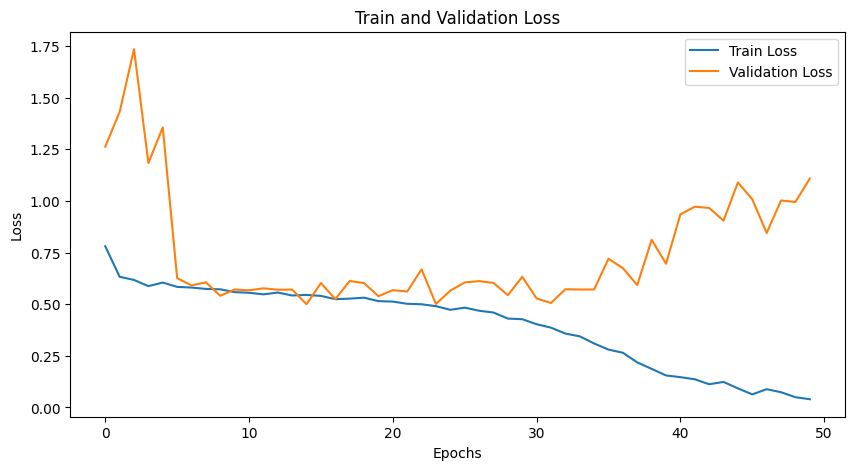

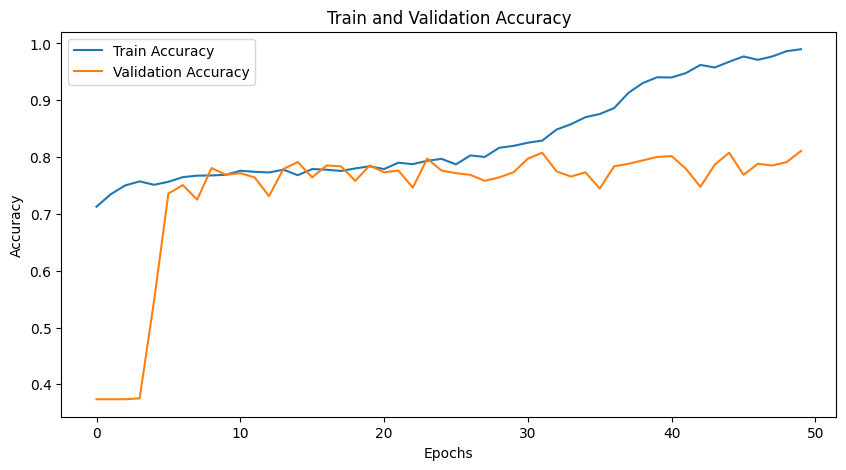

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Load and preprocess the images
data_dir = '/content/Gradding 3C/Train'
class_names = ['Healthy', 'Mild-to-Moderate', 'Severe-to-Proleferative' ]
img_size = (224, 224)
batch_size = 32
epochs = 50
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create the data generator for training set
train_data_generator = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True, subset='training')

# Create the data generator for validation set
validation_data_generator = datagen.flow_from_directory(data_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True, subset='validation')

# Assuming the model is already defined before compiling
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint callback to save best weights based on validation accuracy
# Define the ModelCheckpoint callback to save best weights based on validation accuracy
best_weights_path = '/content/Split/Save/best_model.keras'
checkpoint = ModelCheckpoint(best_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model and get the training history
history = model.fit(train_data_generator, epochs=epochs, validation_data=validation_data_generator, verbose=1, callbacks=[checkpoint])

# Plot train and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

# Plot train and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.show()

# Fold#1 Test ResNet-18

In [4]:
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved best weights
best_weights_path = '/content/Split/Save/best_model.keras'
model.load_weights(best_weights_path)

# Define the dataset directory
TestSet = '/content/Gradding 3C/Test'

# Create an ImageDataGenerator for test data
datagen = ImageDataGenerator(rescale=1.0/255)  # You can add other preprocessing steps here

test_data_generator = datagen.flow_from_directory(
    TestSet,
    target_size=img_size,  # Set your target image size (e.g., (224, 224))
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle the test data
)

# Get true labels and predicted labels
y_true = test_data_generator.classes
y_pred = np.argmax(model.predict(test_data_generator), axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1)

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Found 838 images belonging to 3 classes.
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step
Test Accuracy: 0.7852028639618138
Test Precision: 0.782262673980785
Test Recall: 0.7852028639618138
Test F1-score: 0.7642993279749478
Confusion Matrix:
[[361  33   1]
 [ 31 267  15]
 [  5  95  30]]
